# Index:

In [ ]:
current_configuration = "3-5"
background = "white"
user = "user1"

# IGNORE - Save the data in spreadsheet

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

import glob
import pandas as pd
import numpy as np

import json

from datetime import datetime
import re

def get_id(data):
  return re.sub('[^\d]','', data.get("datetime"))

def get_skeleton_positions(data):
# Extracting local positions of Skeleton0 to Skeleton23
  skeleton_positions = {}
  for key, value in data["values"].items():
      if value["Name"].startswith("Skeleton") and value["Name"] != "Skeleton" :
          joint_name = value["Name"]
          #local_position = value["LocalPosition"]
          local_position = value["Position"]
          skeleton_positions[joint_name] = local_position
  return skeleton_positions


def get_floor_positions(data):
  for key, value in data["values"].items():
      if value["Name"] == "Floor":
          floor_position = value["Position"]
          return floor_position
  return None


def get_bubble_generator_positions(data):
  bubble_generators_positions = {}
  for key, value in data["values"].items():
      if value["Name"].startswith("BubbleGen") and value["Name"] != "BubbleGenerators" and value["Name"] != "BubbleGen4"  and value["Name"] != "BubbleGen5" :
          bubble_generator_name = value["Name"]
          bubble_generator_positions = value["Position"]
          bubble_generators_positions[bubble_generator_name] = bubble_generator_positions
  return bubble_generators_positions


def read_json_data(path):
  skeletons = []

  for elem in open(path):
    skelerton_data = {}
    entry = json.loads(elem)
    skelerton_data['ID'] = get_id(entry)
    skelerton_data['Joints'] = get_skeleton_positions(entry)
    skelerton_data['Floor'] = get_floor_positions(entry)
    skelerton_data['BubbleGenerators'] = get_bubble_generator_positions(entry)
    skeletons.append(skelerton_data)

  return skeletons


# Initialize a global variable for the ID
global_id_counter = 1

def get_global_id():
    """
    Get and increment the global ID counter.

    Returns:
    int: The current global ID.
    """
    global global_id_counter
    current_id = global_id_counter
    global_id_counter += 1
    return current_id


def data_to_dataframe(data_entries):
    """
    Convert multiple JSON data entries into a single pandas DataFrame with columns for joints, floor, bubble generators,
    and target columns like 'Resemble Skeleton', 'Above Floor', and 'Can Reach Bubbles'.

    Parameters:
    data_entries (list of dict): List of JSON objects containing 'ID', 'Joints', 'Floor', and 'BubbleGenerators'.

    Returns:
    pd.DataFrame: DataFrame containing all entries with global simple IDs and columns for joints, floor, bubble generators,
                  and target columns.
    """
    records = []

    for entry in data_entries:
        entry_id = entry['ID']
        record = {'GlobalID': get_global_id(), 'EntryID': entry_id}

        # Flatten the Joints data
        for joint in entry['Joints']:
            record[f'{joint}_X'] = entry['Joints'][joint][0]
            record[f'{joint}_Y'] = entry['Joints'][joint][1]
            record[f'{joint}_Z'] = entry['Joints'][joint][2]

        # Flatten the Bubble Generators data
        for generator in entry['BubbleGenerators']:
            record[f'{generator}_X'] = entry['BubbleGenerators'][generator][0]
            record[f'{generator}_Y'] = entry['BubbleGenerators'][generator][1]
            record[f'{generator}_Z'] = entry['BubbleGenerators'][generator][2]

        # Add Floor data
        record['Floor_X'] = entry['Floor'][0]
        record['Floor_Y'] = entry['Floor'][1]
        record['Floor_Z'] = entry['Floor'][2]

        record['Spatial'] = ''
        record['Temporal'] = ''

        record['Spatial_2'] = ''
        record['Temporal_2'] = ''

        # Append the record to the list of records
        records.append(record)

    # Create DataFrame from records
    df = pd.DataFrame(records,dtype=str)
    return df



def combine_json_files(directory_path):
    """
    Combines all JSON files in the specified directory into a single DataFrame.

    Parameters:
    - directory_path: Path to the directory containing JSON files.

    Returns:
    - Combined DataFrame containing data from all JSON files.
    """
    # List all JSON files in the directory
    file_paths = glob.glob(f'{directory_path}/*.json')

    print(f"Found {len(file_paths)} JSON files in the directory.")
    print(file_paths)

    # List to hold DataFrames
    dfs = []

    # Read each JSON file into a DataFrame and append to list
    for file_path in file_paths:
        new_df = data_to_dataframe(read_json_data(file_path))
        dfs.append(new_df)

    combined_df = pd.DataFrame()

    if len(dfs)>0:
      # Combine all DataFrames into a single DataFrame
      combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

# Example usage
path = 'phantomLimb-test-person'+current_configuration+'fps-'+background
directory_path = '/content/gdrive/MyDrive/data/' + path
combined_df = combine_json_files(directory_path)



combined_df

In [ ]:
import os
from gspread_dataframe import set_with_dataframe

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


# Create a new Google Sheet
spreadsheet_name = 'PhantomLimb-Data-Test-person'+current_configuration+'fps-'+background
#spreadsheet = gc.open(spreadsheet_name)
spreadsheet = gc.create(spreadsheet_name)
worksheet = spreadsheet.get_worksheet(0)

combined_df['EntryID'] = combined_df['EntryID'].astype(str)

# Convert DataFrame to Google Sheets
set_with_dataframe(worksheet, combined_df,string_escaping='full')

print(f"DataFrame saved to Google Sheets: {spreadsheet_name}")

DataFrame saved to Google Sheets: PhantomLimb-Data-Test-person1-5fps-black


# Guidelines

Please read the labeling guidelines before you start.

# Read the data from spreadsheet: --TODO--

**Error handling:**

In order to access a shared with you folder or file in Google Colab you have to:





1.   Go to **Shared with me** in Google Drive.
2.   Select the folder or file you want to acess.
3.   Right click on it and choose **Add shortcut to drive**.
4.   A pop-up window will apear, Select **MyDrive** then click on **Add Shortcut**.
5.   Now, Go to your Google Colab Notebook and mount to Google Drive with:

```
from google.colab import drive

drive.mount("/content/gdrive")
```




**Note**: If the solution above doesn't work , please add the spreadsheet in your google drive root location.



In [ ]:
## TODO: Edit the file paths accordingly
DRIVE_PATH = "/content/gdrive"

WORKSHEET_FILE_NAME = "PhantomLimb-Data-Test-person3-5fps-white"

# TODO: update paths
IMG_FOLDER_PATH = '/content/gdrive/data/phantomLimb-test-person3-5fps-white/image_log'

# Change the column name according to your assignment
if user == 'user1':
  _SPATIAL_COLUMN = 'Spatial'
  _TEMPORAL_COLUMN = 'Temporal'
elif user == 'user2':
  _SPATIAL_COLUMN = 'Spatial_2'
  _TEMPORAL_COLUMN = 'Temporal_2'
else:
  _SPATIAL_COLUMN = 'Spatial_anon'
  _TEMPORAL_COLUMN = 'Temporal_anon'


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import pandas as pd

# Authenticate and create a gspread client
creds, _ = default()
gc = gspread.authorize(creds)

# the code to mount the drive
from google.colab import drive

drive.mount(DRIVE_PATH, force_remount=True)

# Open the Google Sheet and get the data
worksheet = gc.open(WORKSHEET_FILE_NAME).sheet1

# Get all values from the worksheet
rows = worksheet.get_all_values()

# Create a DataFrame, specifying the first row as header
df = pd.DataFrame(rows[1:], columns=rows[0])

# Print the DataFrame to verify
df

Mounted at /content/gdrive


,GlobalID,EntryID,Skeleton0_X,Skeleton0_Y,Skeleton0_Z,Skeleton1_X,Skeleton1_Y,Skeleton1_Z,Skeleton2_X,Skeleton2_Y,...,Temporal_2,RightKneeAngle,LeftKneeAngle,RightElbowAngle,LeftElbowAngle,RightFootDistanceFromFloor,LeftFootDistanceFromFloor,Total_reach,Spatial_1,Temporal_1
0,1,01292025065543090,-0.4412187,2.788617,-2.631137,-0.447164,2.650968,-2.596402,-0.4648522,2.225708,...,0,126.1572886,125.8923793,144.671787,151.7549887,-0.4428003,-0.3988067,1.70122485,0,0
1,2,01292025065544530,-0.7562886,3.112413,-6.680346,-0.7578268,2.967402,-6.62356,-0.7647656,2.522283,...,1,122.1439953,121.5746514,144.9580935,151.7534677,-0.1218566,-0.0817425,1.686209355,0,1
2,3,01292025065544630,-0.7613499,3.121162,-6.758808,-0.7620385,2.976111,-6.689733,-0.7668318,2.526971,...,1,119.2582661,118.6476915,144.051507,151.5224387,-0.1128118,-0.0773702,1.686425099,0,1
3,4,01292025065544811,-0.7698044,3.062317,-6.991748,-0.7698481,2.925143,-6.895802,-0.7717068,2.499637,...,1,116.3016761,115.7465791,146.7769484,157.4700438,-0.1079498,-0.0761192,1.690316816,0,1
4,5,01292025065544985,-0.7723906,2.999416,-7.1991,-0.7723734,2.863475,-7.102793,-0.775574,2.440165,...,1,119.1145094,118.6470484,150.5524521,154.6519179,-0.1622714,-0.1318733,1.633723794,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71,01292025065558206,-0.6193193,3.223347,-5.520962,-0.629877,3.091837,-5.509734,-0.6639943,2.68957,...,0,85.35288273,84.6933084,135.3689539,156.0500418,0.3586757,0.4182467,1.919441082,1,0
71,72,01292025065558402,-0.621051,3.226017,-5.522923,-0.6309885,3.094022,-5.511543,-0.6636721,2.691016,...,0,71.12606454,70.95363602,135.5131768,161.2303089,0.3927437,0.4140137,1.911834777,1,0
72,73,01292025065558595,-0.6247624,3.230786,-5.536699,-0.6329679,3.098225,-5.523254,-0.6618032,2.693131,...,0,73.82239715,73.6532983,134.858192,159.8513441,0.4134837,0.4367207,1.839258201,1,0
73,74,01292025065558798,-0.6244183,3.231735,-5.577646,-0.6318471,3.099404,-5.557774,-0.6581705,2.693653,...,0,78.43072659,78.25272733,132.2908121,156.7589653,0.4123917,0.4384977,1.800096362,1,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-process tabular data

In [ ]:
import numpy as np


def calculate_angle(joint_a, joint_b, joint_c):
    """
    Calculate the angle between the vector AB and BC where A, B, and C are joints.
    """
    vec_ab = np.array(joint_a) - np.array(joint_b)
    vec_bc = np.array(joint_c) - np.array(joint_b)
    cosine_angle = np.dot(vec_ab, vec_bc) / (np.linalg.norm(vec_ab) * np.linalg.norm(vec_bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)



def distance(joint1, joint2):
    return np.linalg.norm(np.array(joint1) - np.array(joint2))

def get_total_reach(joint_positions):
    # Define the key bones
    skeleton_bones = {
        'thigh_left': distance(joint_positions['Skeleton22'], joint_positions['Skeleton21']),
        'lower_leg_left': distance(joint_positions['Skeleton23'], joint_positions['Skeleton22']),
        'thigh_right': distance(joint_positions['Skeleton19'], joint_positions['Skeleton18']),
        'lower_leg_right': distance(joint_positions['Skeleton20'], joint_positions['Skeleton19']),
        'hip_right': distance(joint_positions['Skeleton3'], joint_positions['Skeleton18']),
        'hip_left': distance(joint_positions['Skeleton3'], joint_positions['Skeleton21']),
    }

    # Calculate the total reach (hip + thigh + lower leg)
    reach_left = skeleton_bones['hip_left'] + skeleton_bones['thigh_left'] + skeleton_bones['lower_leg_left']
    reach_right = skeleton_bones['hip_right'] + skeleton_bones['thigh_right'] + skeleton_bones['lower_leg_right']
    total_reach = max(reach_left, reach_right)

    return total_reach

def calculate_skeleton_metrics(df):
    """
    Calculate angles and distances and save them in the DataFrame.

    Parameters:
    - df: DataFrame containing skeleton data.

    Returns:
    - df: Updated DataFrame with calculated angles and distances.
    """
    for index, row in df.iterrows():
        # Convert relevant columns to float (if needed)
        df['Floor_Y'] = df['Floor_Y'].astype(float)

        # Extract x, y, z coordinates from skeleton_positions
        x = [float(row[f'Skeleton{i}_X']) for i in range(24)]
        y = [float(row[f'Skeleton{i}_Y']) for i in range(24)]
        z = [float(row[f'Skeleton{i}_Z']) for i in range(24)]

        # Calculate angles for knees and elbows
        df.at[index, 'RightKneeAngle'] = calculate_angle((x[18], y[18], z[18]), (x[19], y[19], z[19]), (x[20], y[20], z[20]))
        df.at[index, 'LeftKneeAngle'] = calculate_angle((x[21], y[21], z[21]), (x[22], y[22], z[22]), (x[23], y[23], z[23]))
        df.at[index, 'RightElbowAngle'] = calculate_angle((x[8], y[8], z[8]), (x[9], y[9], z[9]), (x[10], y[10], z[10]))
        df.at[index, 'LeftElbowAngle'] = calculate_angle((x[13], y[13], z[13]), (x[14], y[14], z[14]), (x[15], y[15], z[15]))

        # Calculate distances from the floor (using the Y coordinates for vertical distance)
        df.at[index, 'RightFootDistanceFromFloor'] = y[20] - float(row['Floor_Y'])
        df.at[index, 'LeftFootDistanceFromFloor'] = y[23] - float(row['Floor_Y'])

        skeleton_positions = {f'Skeleton{i}': (float(row[f'Skeleton{i}_X']), float(row[f'Skeleton{i}_Y']), float(row[f'Skeleton{i}_Z'])) for i in range(24)}

        df.at[index, 'Total_reach'] = get_total_reach(skeleton_positions)

    return df

df = calculate_skeleton_metrics(df)
df

,GlobalID,EntryID,Skeleton0_X,Skeleton0_Y,Skeleton0_Z,Skeleton1_X,Skeleton1_Y,Skeleton1_Z,Skeleton2_X,Skeleton2_Y,...,Temporal_2,RightKneeAngle,LeftKneeAngle,RightElbowAngle,LeftElbowAngle,RightFootDistanceFromFloor,LeftFootDistanceFromFloor,Total_reach,Spatial_1,Temporal_1
0,1,01292025065245219,-0.6266201,3.060217,-2.889845,-0.618266,2.92371,-2.83906,-0.5951966,2.501195,...,0,169.307513,169.268641,156.534141,155.210713,-0.349101,-0.351582,1.733679,0,0
1,2,01292025065246972,-0.6280981,3.010686,-6.717094,-0.6303657,2.87729,-6.665821,-0.6394923,2.463569,...,1,170.743124,171.013867,156.382981,158.89415,-0.372268,-0.353659,1.731222,0,1
2,3,01292025065248007,-0.8192545,2.981836,-6.855268,-0.8129085,2.854222,-6.778768,-0.7958289,2.459123,...,1,114.766577,115.004014,154.432532,157.051892,-0.139427,-0.139592,1.705105,0,0
3,4,01292025065249022,-0.6895066,3.165101,-6.11311,-0.6924121,3.035133,-6.097306,-0.7017516,2.637335,...,1,127.008182,126.507812,135.617312,149.760137,-0.04228,-0.015027,1.739623,0,0
4,5,01292025065250010,-0.6462997,3.127307,-5.550284,-0.6551844,3.004007,-5.572581,-0.6811299,2.622756,...,0,102.034094,101.999148,140.173976,151.38253,0.419805,0.488601,1.803423,1,0
5,6,01292025065251013,-0.6121992,3.106491,-5.597929,-0.6106312,2.981779,-5.621846,-0.5867474,2.60398,...,0,161.249928,159.134158,137.278024,145.274566,1.292959,1.354429,1.933272,0,0
6,7,01292025065251994,-0.6108717,3.111518,-5.669948,-0.6026943,2.990113,-5.693025,-0.6081598,2.594526,...,0,105.12417,106.21224,132.094231,146.168346,0.407473,0.450231,1.888077,1,0
7,8,01292025065253011,-0.6049554,3.123664,-5.762877,-0.6156828,2.997552,-5.766567,-0.6541673,2.608714,...,0,93.561705,93.978208,136.894207,156.550714,0.158749,0.251908,1.906438,1,0
8,9,01292025065253977,-0.589923,3.122001,-5.766665,-0.6038662,2.997108,-5.772788,-0.6458524,2.613545,...,0,108.446296,108.295183,137.909818,157.619373,0.493981,0.613684,1.736473,1,0
9,10,01292025065255006,-0.5852865,3.121621,-5.764729,-0.5985671,2.996943,-5.770093,-0.6418626,2.614183,...,0,77.303539,77.290227,136.346997,102.900324,0.26412,0.335315,1.935142,1,0


# Functions to plot the skeleton.

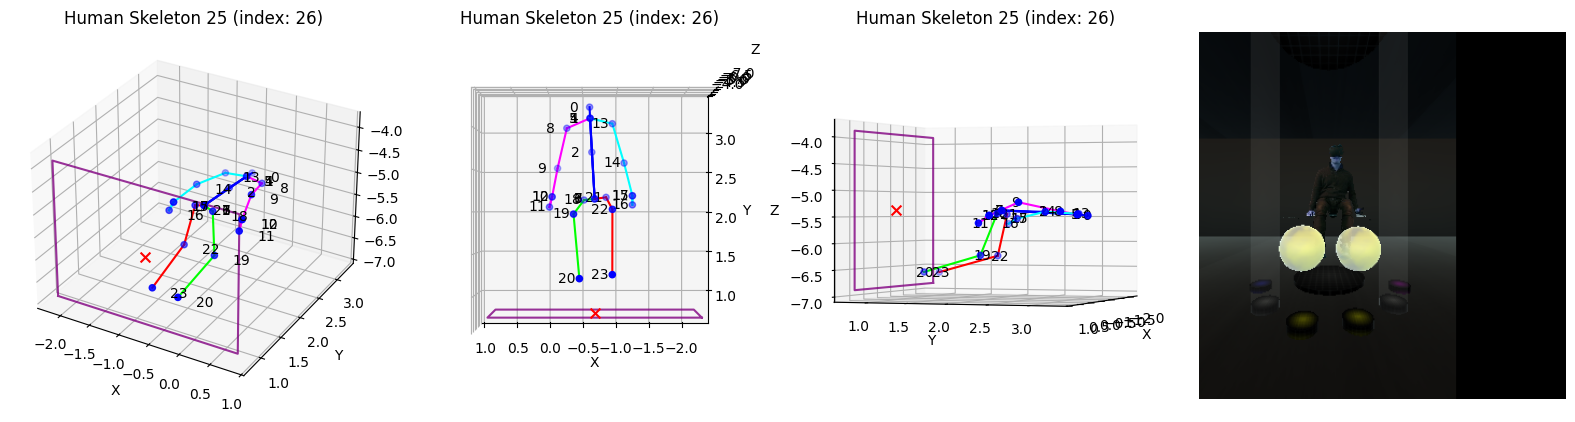

Execution time for plotting: 1.0818 seconds


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import cv2 as cv
import time

plt.ioff()

# List of bones to connect between joints with color mapping
bones = {
    'spine': [(0, 1), (1, 2), (2, 3), (3, 4),(3,6),(3,7), (4,5), (5,6), (6,7)],  # Spine and head
    'right_arm': [(4,8),(8,9), (9,10), (10,11), (11,12)],  # Right arm
    'left_arm': [(5,13),(13,14), (14,15), (15,16), (16,17)],  # Left arm
    'right_leg': [(6,18),(18,19), (19,20)],  # Right leg
    'left_leg': [(7,21),(21,22), (22,23)]  # Left leg
}

# Color mapping for each limb
limb_colors = {
    'spine': 'blue',
    'right_arm': 'fuchsia',
    'left_arm': 'cyan',
    'right_leg': 'lime',
    'left_leg': 'red'
}

def plot_skeleton_and_floor_from_dataframe(df, index):
    """
    Plots the skeleton and floor from a specific row in the DataFrame in three different views.
    Uses pre-calculated angles and distances from the DataFrame.
    """
    row = df.iloc[index]

    # Extract x, y, z coordinates from skeleton_positions using numpy for better performance
    skeleton_positions = np.array([[float(row[f'Skeleton{i}_X']),
                                     float(row[f'Skeleton{i}_Y']),
                                     float(row[f'Skeleton{i}_Z'])] for i in range(24)])

    x, y, z = skeleton_positions[:, 0], skeleton_positions[:, 1], skeleton_positions[:, 2]

    # Create a figure with 3 subplots
    fig = plt.figure(figsize=(16, 4))

    # Prepare the views
    views = [(fig.add_subplot(141, projection='3d'), 'default'),
             (fig.add_subplot(142, projection='3d'), (-90, 90)),
             (fig.add_subplot(143, projection='3d'), (0, 20))]

    for ax, view in views:
        if isinstance(view, tuple):  # Set view angles if they are provided as tuples
            ax.view_init(elev=view[0], azim=view[1])
        plot_skeleton(ax, x, y, z, bones, (row['Skeleton3_X'], row['Floor_Y'], row['Skeleton3_Z']),
                      title=f'Human Skeleton {row["GlobalID"]} (index: {index+2})')

    # Plot the image
    ax4 = fig.add_subplot(144)
    img_path = f'{IMG_FOLDER_PATH}/{row["EntryID"]}.png'
    img = cv.imread(img_path)
    ax4.imshow(img)
    ax4.axis('off')  # Hide axis for the image

    plt.tight_layout()
    plt.show()

def plot_skeleton(ax, x, y, z, bones, floor_positions, title):
    """
    Helper function to plot skeleton and floor on a given axis.
    """
    offset = 0.3  # Adjust the offset for better readability

    # Plot joints as scatter points with annotations
    ax.scatter(x, y, z, color='b', s=20, marker='o')
    for i in range(len(x)):
        ax.text(x[i] + offset, y[i], z[i], str(i), color='black', fontsize=10, ha='left', va='center')

    # Plot bones as lines between joints with color coding
    for limb, limb_bones in bones.items():
        color = limb_colors[limb]
        for joint_from, joint_to in limb_bones:
            ax.plot([x[joint_from], x[joint_to]], [y[joint_from], y[joint_to]], [z[joint_from], z[joint_to]], color=color)

    # Get floor position data
    floor_x, floor_y, floor_z = map(float, floor_positions)

    # Define floor dimensions (adjust based on your data)
    floor_width = 3.0  # Adjust width of the floor
    floor_depth = 3.0  # Adjust depth of the floor

    # Calculate square floor corner coordinates (centered at floor position)
    floor_x_min = floor_x - floor_width / 2
    floor_x_max = floor_x + floor_width / 2
    floor_z_min = floor_z - floor_depth / 2
    floor_z_max = floor_z + floor_depth / 2

    # Plot the floor square as a rectangle with four lines (on the X-Z plane)
    ax.plot([floor_x_min, floor_x_min, floor_x_max, floor_x_max, floor_x_min],
            [floor_y] * 5,
            [floor_z_min, floor_z_max, floor_z_max, floor_z_min, floor_z_min], color='purple', alpha=0.8)

    ax.scatter(floor_x, floor_y, floor_z, color='r', s=50, marker='x')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

# Plot skeleton using pre-calculated metrics for a specific row
index = 24  # Replace with the actual index you want to plot
start_time = time.time()  # Start timing
plot_skeleton_and_floor_from_dataframe(df, index)
end_time = time.time()  # End timing
execution_time = end_time - start_time  # Calculate the execution time
print(f"Execution time for plotting: {execution_time:.4f} seconds")  # Print execution time



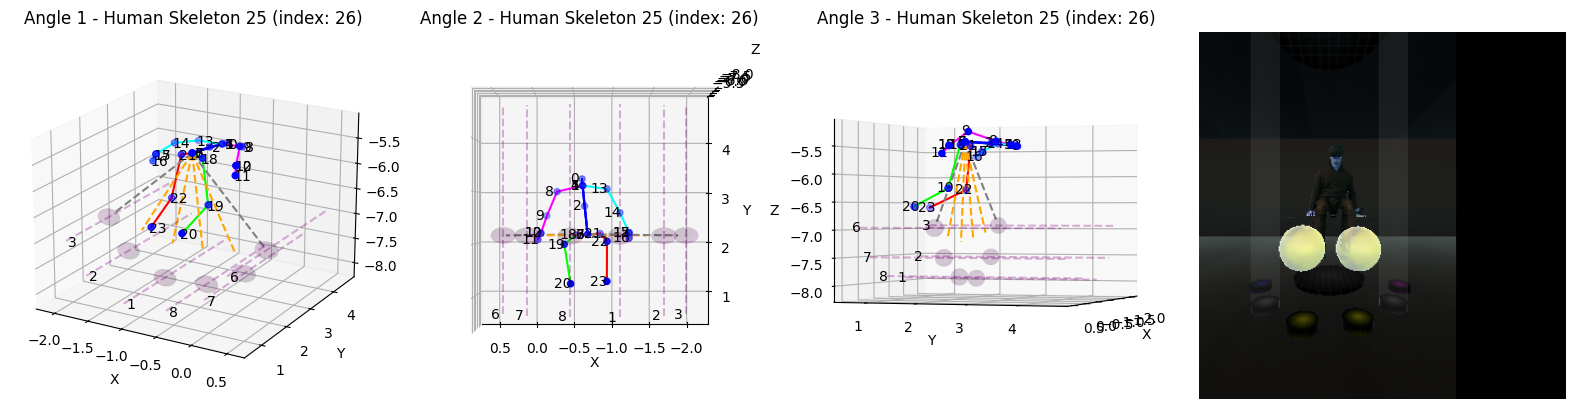

Execution time for plotting: 10.0582 seconds


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time

plt.ioff()

# List of bones to connect between joints with color mapping
bones = {
    'spine': [(0, 1), (1, 2), (2, 3), (3, 4), (3, 6), (3, 7), (4, 5), (5, 6), (6, 7)],
    'right_arm': [(4, 8), (8, 9), (9, 10), (10, 11), (11, 12)],
    'left_arm': [(5, 13), (13, 14), (14, 15), (15, 16), (16, 17)],
    'right_leg': [(6, 18), (18, 19), (19, 20)],
    'left_leg': [(7, 21), (21, 22), (22, 23)]
}

# Color mapping for each limb
limb_colors = {
    'spine': 'blue',
    'right_arm': 'fuchsia',
    'left_arm': 'cyan',
    'right_leg': 'lime',
    'left_leg': 'red'
}

# Bubble radius
bubble_radius = 0.159

def plot_skeleton_and_bubble_generators_with_reach_from_dataframe(df, index):
    """Plots the skeleton and bubble generators with reach from a specific row in the DataFrame."""
    # Extract the row and relevant data
    row = df.iloc[index]
    id = row['GlobalID']

    # Extract total reach from the row
    total_reach = float(row['Total_reach'])

    # Extract bubble generators and skeleton positions
    bubble_generators = {
        f'BubbleGenerator{i}': (
            float(row[f'BubbleGen{i}_X']),
            float(row[f'BubbleGen{i}_Y']),
            float(row[f'BubbleGen{i}_Z'])
        ) for i in [1, 2, 3, 6, 7, 8]
    }

    skeleton_positions = np.array([
        [float(row[f'Skeleton{i}_X']), float(row[f'Skeleton{i}_Y']), float(row[f'Skeleton{i}_Z'])]
        for i in range(24)
    ])

    fig = plt.figure(figsize=(16, 4))

    # Create axes for different views
    angles = [(20, -60, 'Angle 1'), (-90, 90, 'Angle 2'), (0, 20, 'Angle 3')]
    axes = [fig.add_subplot(141 + i, projection='3d') for i in range(3)]

    # Precompute sphere coordinates for the bubble generators
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_sphere = bubble_radius * np.outer(np.cos(u), np.sin(v))
    y_sphere = bubble_radius * np.outer(np.sin(u), np.sin(v))
    z_sphere = bubble_radius * np.outer(np.ones(np.size(u)), np.cos(v))

    # Plotting all views
    for ax, (elev, azim, angle) in zip(axes, angles):
        plot_skeleton_and_bubbles(ax, skeleton_positions, bubble_generators, total_reach, f'{angle} - Human Skeleton {id} (index: {index+2})', elev, azim, x_sphere, y_sphere, z_sphere)

    # Load and display the image
    img_path = f'{IMG_FOLDER_PATH}/{row["EntryID"]}.png'
    img = cv.imread(img_path)
    ax4 = fig.add_subplot(144)
    ax4.imshow(img)
    ax4.axis('off')  # Hide the axes for the image

    plt.tight_layout()
    plt.show()

def plot_skeleton_and_bubbles(ax, skeleton_positions, bubble_generators, total_reach, title, elev=20, azim=-60, x_sphere=None, y_sphere=None, z_sphere=None):
    """Plots the skeleton and bubble generators with reach lines."""

    def plot_reach_line(ax, start, end, reach):
        total_length = np.linalg.norm(start - end)
        color = 'lightgray' if total_length <= reach else 'orange' if total_length > reach + bubble_radius else 'gray'

        if total_length <= reach:
            ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color=color, linestyle='--')
        else:
            scale_factor = reach / total_length
            reachable_point = start + scale_factor * (end - start)
            ax.plot([start[0], reachable_point[0]], [start[1], reachable_point[1]], [start[2], reachable_point[2]], color=color, linestyle='--')

    # Plot joints
    ax.scatter(skeleton_positions[:, 0], skeleton_positions[:, 1], skeleton_positions[:, 2], color='b', s=20, marker='o')
    for i in range(skeleton_positions.shape[0]):
        ax.text(skeleton_positions[i, 0] + 0.1, skeleton_positions[i, 1], skeleton_positions[i, 2], i, color='black', fontsize=10, ha='center', va='center')

    # Plot bones
    for limb, limb_bones in bones.items():
        color = limb_colors[limb]
        for bone in limb_bones:
            ax.plot(*zip(skeleton_positions[bone[0]], skeleton_positions[bone[1]]), color=color)

    # Plot Bubble Generators and reach lines
    for key, pos in bubble_generators.items():
        ax.text(pos[0] + 0.1, pos[1], pos[2], key[-1], fontsize=10, ha='center', va='center')
        ax.plot([pos[0], pos[0]], [pos[1], pos[1] + 4.0], [pos[2], pos[2]], color='purple', linestyle='--', alpha=0.3)

        # Plot a sphere at Skeleton3 height
        skeleton3_y = skeleton_positions[3, 1]  # Skeleton3 corresponds to index 3
        ax.plot_surface(pos[0] + x_sphere, skeleton3_y + y_sphere, pos[2] + z_sphere, color='purple', alpha=0.1)

        # Plot a reach line from Skeleton3 to bubble generators
        plot_reach_line(ax, skeleton_positions[3], [pos[0], skeleton3_y, pos[2]], total_reach)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.view_init(elev=elev, azim=azim)

# Example usage
index = 24  # Replace with the actual index you want to plot
start_time = time.time()  # Start timing
plot_skeleton_and_bubble_generators_with_reach_from_dataframe(df, index)
end_time = time.time()  # End timing
execution_time = end_time - start_time  # Calculate the execution time
print(f"Execution time for plotting: {execution_time:.4f} seconds")  # Print execution time


# Interactive labeling functions

**TODO:** please make sure your assigned label column is displayed in




### Spatial:

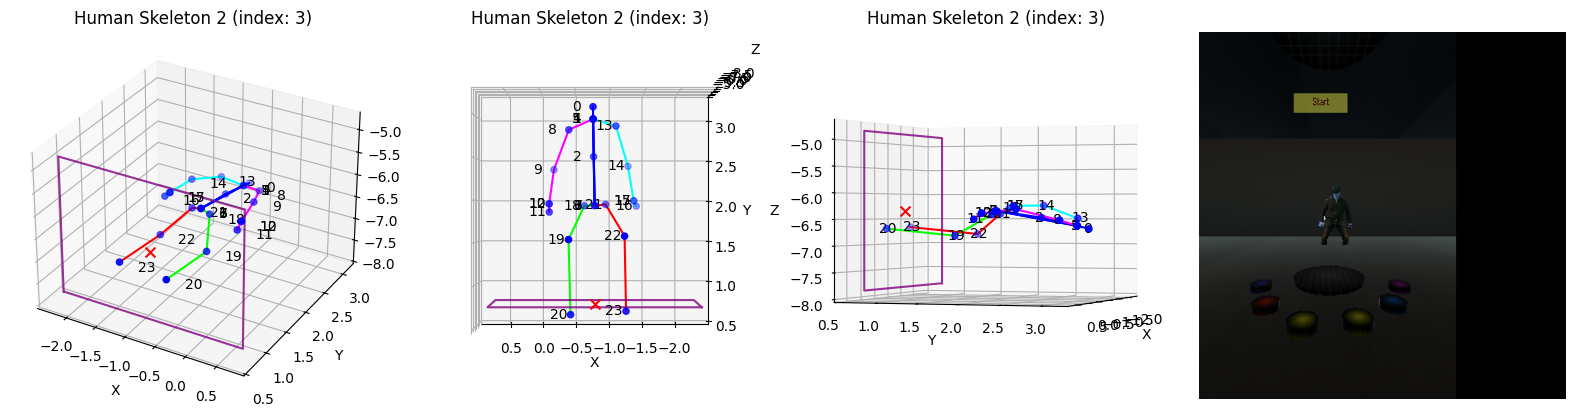

In [ ]:
from ipywidgets import widgets, HBox, VBox, Output
import gspread
from gspread_dataframe import set_with_dataframe

def interactive_plot_and_label(df, index):
    # Fetch values from the DataFrame once and store them
    # spatial_value = df.at[index, 'Spatial']  # Example of accessing a single cell
    spatial_label_column = _SPATIAL_COLUMN  # Change this based on your logic

    def on_button_click(b):
        # Change the button color immediately to provide feedback
        b.style.button_color = 'lightgreen'

        # Update the DataFrame with the selected label
        df.at[index, spatial_label_column] = int(label_spatial.value)  # Convert to int

        # Update Google Sheets with the new DataFrame (consider batching if needed)
        set_with_dataframe(worksheet, df, include_index=False)  # You might want to include index if needed
        print(f"Labels updated for index {index + 2} with {label_spatial.value}.")

    # Plot the skeleton and floor
    plot_skeleton_and_floor_from_dataframe(df, index)

    # Set up radio buttons for spatial labels
    label_spatial = widgets.RadioButtons(
        options=[('0', '0'), ('1', '1')],
        description='Spatial:',
        value='0'  # Set the initial value based on existing data
    )

    # Set up button for updating labels
    button = widgets.Button(description="Update Labels")
    button.on_click(on_button_click)

    # Create a layout using HBox or VBox for better organization
    display(HBox([label_spatial, button]))

interactive_plot_and_label(df, 1)

### Temporal:


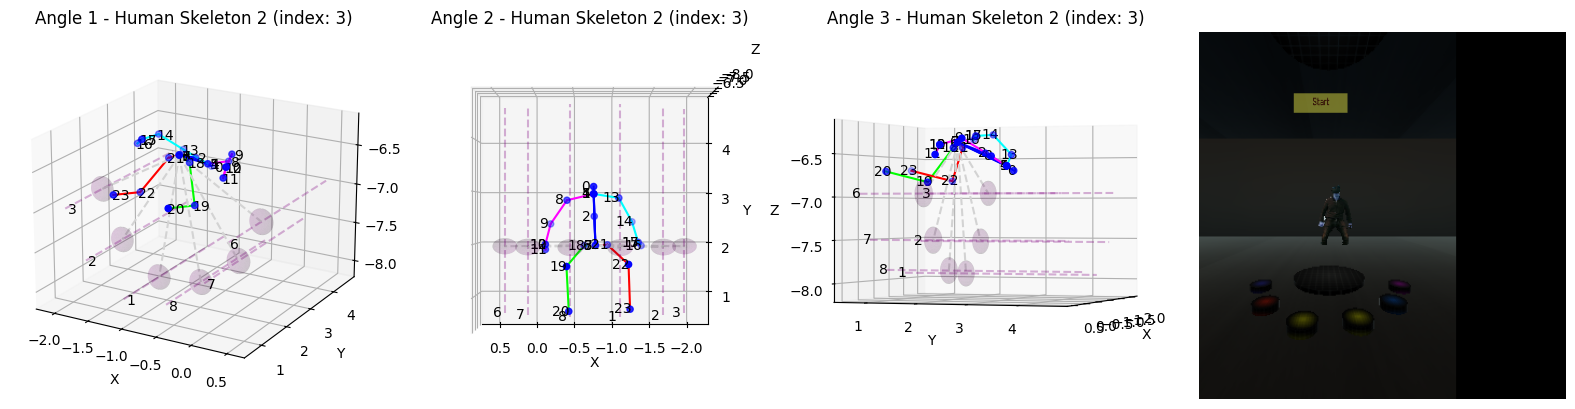

In [ ]:
from ipywidgets import widgets, HBox
import gspread
from gspread_dataframe import set_with_dataframe

def interactive_plot_and_label_bubbles(df, index):
    # Define the Temporal label column
    temporal_label_column = _TEMPORAL_COLUMN  # Change based on your logic

    def on_button_click(b):
        # Change the color of the button for immediate feedback
        b.style.button_color = 'lightgreen'

        # Update the DataFrame with the selected label
        df.at[index, temporal_label_column] = int(label_temporal.value)  # Convert to int

        # Update Google Sheets with the new DataFrame
        set_with_dataframe(worksheet, df, include_index=False)  # You might want to include index if needed
        print(f"Labels updated for index {index + 2}.")

    # Plot the skeleton and bubble generators
    plot_skeleton_and_bubble_generators_with_reach_from_dataframe(df, index)

    # Set up radio buttons for temporal labels
    label_temporal = widgets.RadioButtons(
        options=[('0', '0'), ('1', '1')],
        description='Temporal:',
    )

    # Set up button for updating labels
    button = widgets.Button(description="Update Labels")
    button.on_click(on_button_click)

    # Display the radio buttons and button together for better layout
    display(HBox([label_temporal, button]))
interactive_plot_and_label_bubbles(df, 1)

# Usage

**Note:** Change the interval bellow according with your section.

**Note2:** When processing saving the data and getting the data for the new plots , there might be a delay. Please watch the printed comments or the data in the excel table for proof of saving the execution.

## Spatial

In [ ]:
# Plotting and labeling given rows
for index in range(0,75):
    interactive_plot_and_label(df, int(index))

## Temporal

In [ ]:
# Plotting and labeling given rows

for index in range(0,75):
    print(index)
    interactive_plot_and_label_bubbles(df, index)